# Name Entity Recognition (NER) Dataset

Link: https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset

Dataset description:

This is a very clean dataset and is for anyone who wants to try his/her hand on the NER ( Named Entity recognition ) task of NLP.

Tags:

* ORGANIZATION - Georgia-Pacific Corp., WHO
* PERSON - Eddy Bonte, President Obama
* LOCATION - Murray River, Mount Everest
* DATE - June, 2008-06-29
* TIME - two fifty a m, 1:30 p.m.
* MONEY - 175 million Canadian Dollars, GBP 10.40
* PERCENT - twenty pct, 18.75 %
* FACILITY - Washington Monument, Stonehenge
* GPE - South East Asia, Midlothian

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qU transformers
!pip install -qU datasets
!pip install -qU seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 946.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import glob
from pathlib import Path

from transformers import AutoTokenizer, BertForTokenClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from torch.nn.functional import pad
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from tqdm.auto import tqdm
from datasets import load_metric

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# device

## Data preprocessing

In [ ]:
# df = pd.read_csv("/kaggle/input/name-entity-recognition-ner-dataset/NER dataset.csv", encoding='unicode_escape')
# df.rename(columns={"Sentence #": "Sentence"}, inplace=True)

# df["Tag"] = df["Tag"].apply(lambda x: x.upper())
# df["TagGeneral"] = df["Tag"].apply(lambda x: x.split("-")[-1])
# df["TagPos"] = df["Tag"].apply(lambda x: x.split("-")[0])
# df["Word"].fillna("None", inplace=True)

# tag_list = df["Tag"].unique()
# tag_general_list = df["TagGeneral"].unique()

# n_tags = len(tag_list)
# n_tag_general = len(tag_general_list)
# n_tag_general

In [ ]:
#process.py
CYELGREENBG = '\033[43m'
CFUKSIABG = '\033[45m'
CLBLUEBG = '\033[46m'
CGREYBG    = '\33[100m'
CREDBG    = '\33[101m'
CGREENBG  = '\33[102m'
CYELLOWBG = '\33[103m'
CBLUEBG   = '\33[104m'
CVIOLETBG = '\33[105m'
CBEIGEBG  = '\33[106m'
CEND  = '\33[107m'

color_mapping = {'O': CEND, 'GEO': CYELLOWBG, 'GPE': CREDBG, 'PER': CBLUEBG, 'ORG':CVIOLETBG,
                 'TIM': CBEIGEBG, 'ART': CYELGREENBG, 'NAT': CFUKSIABG, 'EVE':CLBLUEBG
                 }

def processing_data(data_path):
    df = pd.read_csv("/content/drive/MyDrive/Deep_Learning/NER_dataset.csv", encoding='unicode_escape')
    df.rename(columns={"Sentence #": "Sentence"}, inplace=True)

    df["Tag"] = df["Tag"].apply(lambda x: x.upper())
    df["TagGeneral"] = df["Tag"].apply(lambda x: x.split("-")[-1])
    df["TagPos"] = df["Tag"].apply(lambda x: x.split("-")[0])
    df["Word"].fillna("None", inplace=True)

    tag_list = df["Tag"].unique()
    tag_general_list = df["TagGeneral"].unique()

    n_tags = len(tag_list)
    n_tag_general = len(tag_general_list)

    tags2ids = {tag: i for i, tag in enumerate(tag_list)}
    ids2tags = {i: tag for i, tag in enumerate(tag_list)}

    df["TagId"] = df["Tag"].map(tags2ids)

    df["Sentence"] = df["Sentence"].fillna(method='ffill')
    df = df.groupby("Sentence").agg(list).reset_index().drop("Sentence", axis=1)

    return df, n_tags, tags2ids, ids2tags

# Show example data with entities named

In [ ]:
# def display_formatted_text(words, tags):
#     formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + CEND
#     print(formatted_text)

# text = df.loc[0, "Word"]
# tags = df.loc[0, "TagGeneral"]
# display_formatted_text(text, tags)

# text = df.loc[42, "Word"]
# tags = df.loc[42, "TagGeneral"]
# display_formatted_text(text, tags)

In [ ]:
# sns.set_palette(palette="Pastel1")
# sns.set_style("whitegrid")

# fig, axs =plt.subplots(2,1, figsize=(11,8))
# sns.countplot(x=df['TagGeneral'], ax=axs[0])
# sns.countplot(x=df['TagGeneral'], ax=axs[1], hue =df["TagPos"])
# axs[0].tick_params(axis='x', rotation=85)
# axs[1].tick_params(axis='x', rotation=85)

# total = len(df)
# for ax in axs:
#     ax.set_yscale("log")
#     for p in ax.patches:
#         percentage = '{:.2f}%'.format(100 * p.get_height()/total)
#         x = p.get_x() + p.get_width()/2
#         y = p.get_height()/2
#         ax.annotate(percentage, (x, y), ha='center', fontsize=10, rotation=0)
# fig.tight_layout()
# fig.show()

## Dataset & Dataloaders

In [ ]:
#dataset.py
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["Word"].values
        self.labels =df["TagId"].values
        self.len = len(self.labels)

    def __getitem__(self, idx):
        encoded_dict = self.tokenizer(self.inputs[idx],
                                 is_split_into_words=True,
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        token_labels = self.__create_token_labels(self.labels[idx], encoded_dict.word_ids())
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], token_labels

    def __create_token_labels(self, labels, word_ids ):
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

    def __len__(self):
        return self.len

def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])

    ids = []
    token_types = []
    attention_masks = []
    labels = []

    for sample in batch:
        pad_length = max_len - len(sample[0])
        ids.append(pad(sample[0], (0, pad_length), value=0))
        token_types.append(pad(sample[1], (0, pad_length), value=0))
        attention_masks.append(pad(sample[2], (0, pad_length), value=0))
        labels.append(pad(sample[3], (0, pad_length), value=-100))

    return torch.stack(ids), torch.stack(token_types), torch.stack(attention_masks), torch.stack(labels)

In [ ]:
#utils.py
def increment_path(path, exist_ok=True, sep=''):
    # Increment path, i.e. runs/exp --> runs/exp{sep}0, runs/exp{sep}1 etc.
    path = Path(path)  # os-agnostic
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}{sep}*")  # similar paths
        matches = [re.search(rf"%s{sep}(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]  # indices
        n = max(i) + 1 if i else 2  # increment number
        return f"{path}{sep}{n}"  # update path

In [ ]:
#evaluate.py
def evaluate(model, dataloader, ids2tags, device):

    metric = load_metric("seqeval")

    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, "Compute metric"):
            output = model(input_ids=batch[0].to(device),
                       token_type_ids=batch[1].to(device),
                       attention_mask=batch[2].to(device),
                       labels=batch[3].to(device))
            labels = batch[3].to('cpu').numpy()
            predictions = torch.argmax(output.logits.detach().cpu(), 2).numpy()

            for prediction, label in zip(predictions, labels):
                for pred_idx, label_idx in zip(prediction, label):
                    if label_idx != -100:
                        all_predictions.append(ids2tags[pred_idx])
                        all_labels.append(ids2tags[label_idx])

    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [ ]:
#train.py
def train(data_path, epochs, batch_size, save_dir="ner_bert/"):
    save_dir = increment_path(save_dir, exist_ok=False)
    save_model_path = save_dir + "/weight"
    save_tokenizer_path = save_dir + "/tokenizer"

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("Processing data...")
    df, n_tags, tags2ids, ids2tags = processing_data(data_path)

    huggingface_model = "bert-base-cased"
    tokenizer = AutoTokenizer.from_pretrained(huggingface_model, do_lower_case=True)
    tokenizer.special_tokens_map

    dataset = CustomDataset(df, tokenizer)
    train_size = int(0.8 * len(dataset))
    validation_size = len(dataset)  - train_size
    train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

    train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

    validation_dataloader = DataLoader(
                validation_dataset,
                sampler = SequentialSampler(validation_dataset),
                batch_size = batch_size,
                collate_fn=collate_fn
            )

    print("Loading model...")
    model = BertForTokenClassification.from_pretrained(
    huggingface_model,
    num_labels = n_tags,
    output_attentions = False,
    output_hidden_states = False,
    ).to(device)

    optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
    avg_train_accuracy = []
    avg_train_loss = []
    avg_val_loss = []
    avg_val_accuracy = []
    print(f"Start training for {epochs} epochs")
    for epoch_i in range(0, epochs):

        running_train_loss = 0
        running_val_loss = 0

        model.train()

        loop = tqdm(train_dataloader)

        for batch in loop:

            optimizer.zero_grad()
            output = model(input_ids=batch[0].to(device),
                           token_type_ids=batch[1].to(device),
                           attention_mask=batch[2].to(device),
                           labels=batch[3].to(device))

            loss = output.loss
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Training. Epoch [{epoch_i}/{epochs}]. Loss {loss.item()}")

        avg_train_loss.append(running_train_loss / train_size)


        model.eval()
        with torch.no_grad():
            loop = tqdm(validation_dataloader)
            for batch in loop:
                output = model(input_ids=batch[0].to(device),
                               token_type_ids=batch[1].to(device),
                               attention_mask=batch[2].to(device),
                               labels=batch[3].to(device))
                loss = output.loss
                running_val_loss += loss.item()
                loop.set_description(f"Validation. Epoch [{epoch_i}/{epochs}]. Loss {loss.item()}")
        avg_val_loss.append(running_val_loss / validation_size)

    #save model
    model.save_pretrained(save_model_path)
    tokenizer.save_pretrained(save_tokenizer_path)
    config = json.load(open(save_model_path + "/config.json"))
    config["id2label"] = ids2tags
    config["label2id"] = tags2ids
    json.dump(config, open(save_model_path + "/config.json", "w"))
    #save model

    metric_result = evaluate(model, validation_dataloader, ids2tags, device)
    print(metric_result)


    list_metric_rs = [metric_result["overall_accuracy"], metric_result["overall_precision"], metric_result["overall_recall"],
                     metric_result["overall_f1"]]
    fig, ax = plt.subplots(1,1, figsize=(11, 5))
    ax.bar([1, 2, 3, 4], list_metric_rs, color=["red", "green", "blue", "black"])
    ax.set_xticks([1, 2, 3, 4], ["accuracy", "precision", "recall", "f1_score"])
    path_save_fig_metric = save_dir + "/overall_results_metric.png"
    plt.savefig(path_save_fig_metric)



    fig, axs = plt.subplots(1,2, figsize=(11, 5), sharex=True, sharey=True)
    axs[0].plot(avg_train_loss)
    axs[0].set_title("Average training loss")
    axs[1].plot(avg_val_loss)
    axs[1].set_title("Average validation loss")
    axs[0].set_xlabel("Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    for row in axs:
         row.grid(c='gray', alpha=0.5)
    path_save_fig = save_dir + "/results_loss.png"
    plt.savefig(path_save_fig)

    print("All result save in:", save_dir)


Processing data...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training for 2 epochs


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Compute metric:   0%|          | 0/300 [00:00<?, ?it/s]

{'ART': {'precision': 0.5384615384615384, 'recall': 0.03111111111111111, 'f1': 0.0588235294117647, 'number': 225}, 'EVE': {'precision': 0.5135135135135135, 'recall': 0.1792452830188679, 'f1': 0.26573426573426573, 'number': 106}, 'GEO': {'precision': 0.841100352909239, 'recall': 0.9045788526105786, 'f1': 0.8716854617494666, 'number': 20551}, 'GPE': {'precision': 0.9496569920844328, 'recall': 0.9410165237398034, 'f1': 0.9453170142354362, 'number': 9562}, 'NAT': {'precision': 0.723404255319149, 'recall': 0.3238095238095238, 'f1': 0.4473684210526316, 'number': 105}, 'ORG': {'precision': 0.6917765996794477, 'recall': 0.6250417734209647, 'f1': 0.6567181647940075, 'number': 8977}, 'PER': {'precision': 0.8125678610206297, 'recall': 0.7787460978147763, 'f1': 0.7952975557917108, 'number': 7688}, 'TIM': {'precision': 0.9167161696566473, 'recall': 0.8941939969869046, 'f1': 0.9053150299190426, 'number': 8629}, 'overall_precision': 0.8450962749685081, 'overall_recall': 0.8409648478770839, 'overall_f

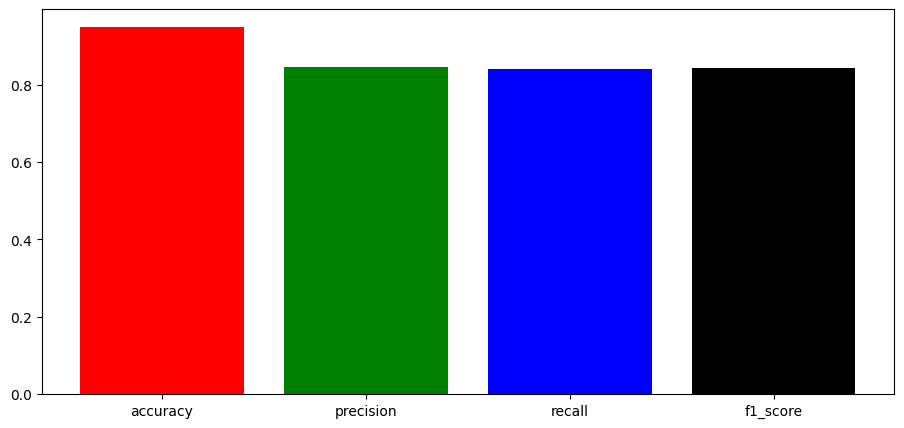

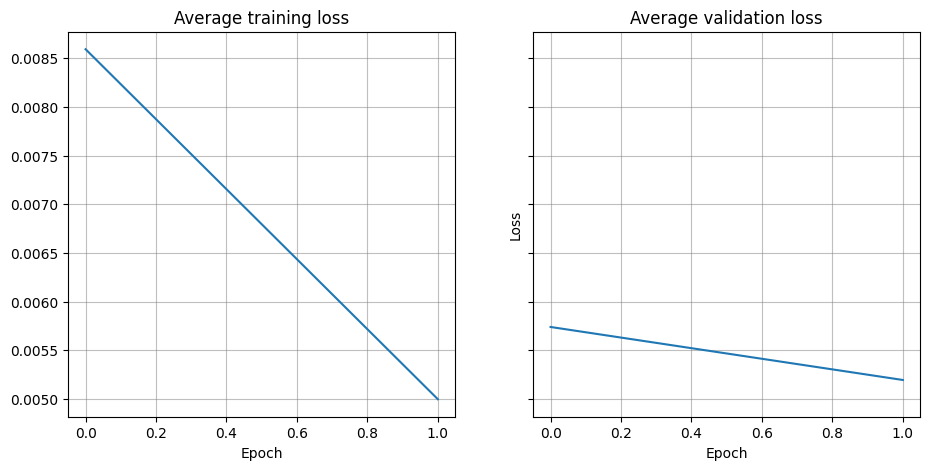

In [ ]:
data_path = '/content/drive/MyDrive/Deep_Learning/NER_dataset.csv'
epochs = 2
batch_size = 32
train(data_path, epochs, batch_size, save_dir="ner_bert/")

# Evaluate

In [ ]:
# evaluate(model, train_dataloader)
#evaluate(model, validation_dataloader)

# Predict tags using hand-made function

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("tokenizer")
# model = BertForTokenClassification.from_pretrained("ner_model")

In [ ]:
from collections import Counter
import torch.nn.functional as F

def get_predicted_tag(word, tags, scores, ids2tags):
    most_common_tag = Counter(tags).most_common()[0][0]
    correct_scores = [score if tag == most_common_tag else -score for score, tag in zip(scores, tags)]
    score = round(sum(correct_scores)/len(correct_scores), 4)
    predicted_tag = ids2tags[str(most_common_tag)].split("-")[-1]
    return {"word": word, "entity_group": predicted_tag, "score": score}


def predict(raw_text, model_path, display_formatted_text = True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weight_path = model_path + "/weight"
    tokenizer_path = model_path + "/tokenizer"
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = BertForTokenClassification.from_pretrained(weight_path)

    config = json.load(open(weight_path + "/config.json"))
    ids2tags=config["id2label"]
    tags2ids=config["label2id"]
    raw_words = raw_text.split()
#     print(raw_words)
    encoded_dict = tokenizer(raw_words,
                             is_split_into_words=True,
                             add_special_tokens = True,
                             return_attention_mask = True,
                             return_tensors = 'pt'
                   )

    input_ids = encoded_dict['input_ids'][0].unsqueeze(0)#.to(device)
    input_token_type = encoded_dict['token_type_ids'][0].unsqueeze(0)#.to(device)
    input_mask = encoded_dict['attention_mask'][0].unsqueeze(0)#.to(device)

    output = model(input_ids, token_type_ids=input_token_type, attention_mask=input_mask)
    normalized_output = F.softmax(output.logits.detach().cpu(), dim=2)
    predictions = torch.max(normalized_output, 2)
    predicted_label = predictions.indices.numpy().flatten()
    predicted_scores = predictions.values.numpy().flatten()

    result = []
    prev_token_id = None

    for token_id, predicted_label, score in zip(encoded_dict.word_ids(), predicted_label, predicted_scores):
        if token_id is None:
            continue
        elif token_id != prev_token_id:
            if prev_token_id is not None:
                result.append(get_predicted_tag(raw_words[prev_token_id],tags, scores, ids2tags))
            tags = []
            scores = []

        tags.append(predicted_label)
        scores.append(score)
        prev_token_id = token_id

    result.append(get_predicted_tag(raw_words[prev_token_id],tags, scores, ids2tags))

    if display_formatted_text:
        formatted_text = " ".join([color_mapping[entity["entity_group"]] + entity["word"] for entity in result]) + CEND
        print(formatted_text)

    return result

In [ ]:
text = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
model_path = "/content/ner_bert"
predict(text, model_path)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country.


[{'word': 'Thousands', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'of', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'demonstrators', 'entity_group': 'O', 'score': 0.9996},
 {'word': 'have', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'marched', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'through', 'entity_group': 'O', 'score': 0.9989},
 {'word': 'London', 'entity_group': 'GEO', 'score': 0.9926},
 {'word': 'to', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'protest', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'war', 'entity_group': 'O', 'score': 0.9994},
 {'word': 'in', 'entity_group': 'O', 'score': 0.9994},
 {'word': 'Iraq', 'entity_group': 'GEO', 'score': 0.9963},
 {'word': 'and', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'demand', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'withdrawal', 'entity_group': 'O', 'score': 0.9998},
 {'w

In [ ]:
text = "Iranian officials say they expect to get access John to sealed sensitive parts of the plant Wednesday"
model_path = "/content/ner_bert"
predict(text, model_path)

Iranian officials say they expect to get access John to sealed sensitive parts of the plant Wednesday


[{'word': 'Iranian', 'entity_group': 'GPE', 'score': 0.9984},
 {'word': 'officials', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'say', 'entity_group': 'O', 'score': 0.9999},
 {'word': 'they', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'expect', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'to', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'get', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'access', 'entity_group': 'O', 'score': 0.9845},
 {'word': 'John', 'entity_group': 'PER', 'score': 0.7766},
 {'word': 'to', 'entity_group': 'O', 'score': 0.9928},
 {'word': 'sealed', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'sensitive', 'entity_group': 'O', 'score': 0.9997},
 {'word': 'parts', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'of', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9998},
 {'word': 'plant', 'entity_group': 'O', 'score': 0.9996},
 {'word': 'Wednesday', 'entity_group': 'TIM', 'score': 0.998}]

In [ ]:
example = input()
model_path = "/content/ner_bert"
predict(example, model_path)

Bach is the best
Bach is the best


[{'word': 'Bach', 'entity_group': 'PER', 'score': 0.6362},
 {'word': 'is', 'entity_group': 'O', 'score': 0.999},
 {'word': 'the', 'entity_group': 'O', 'score': 0.9993},
 {'word': 'best', 'entity_group': 'O', 'score': 0.9972}]